# Sentiment Analysis on Articles Published by the European Central Bank


A significant portion of available data consists of textual information, often created by and for humans. These texts are typically unstructured, and their analysis poses critical challenges across various domains such as healthcare, marketing, and finance. This research project aims to investigate the potential impact of news articles published on the European Central Bank (ECB) [website](https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?) on financial markets.


```Annonce plan```

First, we need to download the data from the ECB website. The function ``get_urls`` retrieves all the article URLs available on the ECB website.

Next, the function ``scrap_content`` takes the URLs as input and extracts the textual content of the articles.

# 1 Get the ECB Data

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import torch

import os
os.makedirs("./utils", exist_ok=True) 

os.makedirs("./data", exist_ok=True) 

In [3]:
%%writefile ./utils_2/scrap.py

#! /usr/bin/env python3
# coding: utf-8

import os
from tqdm import tqdm
import logging as lg
import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import pdfplumber
import pdfplumber
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from urllib3.connectionpool import log as urllibLogger
import requests
from pdfminer.high_level import extract_text
from io import BytesIO


lg.basicConfig(level=lg.INFO)


def extract_text_from_pdf(url):
    response = requests.get(url)

    if response.status_code != 200:
        return "Error"

    with open('temp.pdf', 'wb') as f:
        f.write(response.content)

    with pdfplumber.open('temp.pdf') as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text()
    
    os.remove("temp.pdf")

    return text

def create_webdriver(driver_path=None, active_options=False):
    if active_options:
        options = Options()
        options.add_argument('--headless')
    else:
        options = Options()
    
    if driver_path is not None:
        path_driver = driver_path
    else:
        path_driver = 'chromedriver'
    service = Service()
    

    pager = webdriver.Chrome(service=service, options=options)
    return pager


def scroll(pager, speed=50, last_pos=0):
    """Since we need to load the urls of the page,
    we "auto roll" the page so it load more urls.
    """
    last_height = pager.execute_script("return document.body.scrollHeight")
    for i in range(last_pos, last_height, speed):
        pager.execute_script(f"window.scrollTo({last_pos}, {i});")

    return last_height


def get_page_source(url, pager, scrolling=False, close=False, waiter=60):
    """We open a webdriver, auto roll so it loads more articles, then get the page source containing the urls
    """
    lg.info('Launching driver')
    pager.get(url)


    if scrolling:
        scroll(pager)

        elapsed_time = 0
        interval = 1
        start_time = time.time()
        last_pos=0
        while elapsed_time < waiter:
            last_pos = scroll(pager, speed=50, last_pos=last_pos)
            last_pos -=200

            time.sleep(0.5)
            
            elapsed_time = time.time() - start_time
    page_source = pager.page_source
    
    if close:
        pager.close()
        lg.info('Closing driver')
    
    return page_source


def get_urls(url, page_source):
    """from the page source, we scrap the urls of the articles
    """
    soup = BeautifulSoup(page_source, 'lxml')
    url_root = url.split('/press')[0]
    contents = soup.find_all('dd')
    dates = soup.find_all("dt")

    d = {}
    index = 0
    for dt, ct in zip(dates, contents):
        all_lang = ct.find_all("a")[1:]
        for lang in all_lang:
            if 'href' not in lang.attrs:
                continue

            title_tag = lang.find_previous_sibling("div", class_="title") or lang
            title = title_tag.text.strip() if title_tag else "No title"

            d[index] = {
                'language': lang['lang'] if 'lang' in lang.attrs else "en",
                'url': url_root + lang["href"],
                'title': title,
                'date': dt.text.strip()
            }
            index += 1

    pd.DataFrame.from_dict(d, orient='index').to_csv('data/url.csv')
    # We save the dataframe containing the url cause it is the longest part and we can keep
    # the urls even tho the API crash in the next step

    return pd.DataFrame.from_dict(d, orient='index')


def get_content_article(article):
    """
    Get the content of an article
    """
    content = []

    if article:
        for paragraph in article.find_all('p'):
            content.append(paragraph.text.strip())
    return ' '.join(content)


def extraire_texte_pdf_miner(lien):
        try:
            reponse = requests.get(lien)
            reponse.raise_for_status()

            fichier_pdf = BytesIO(reponse.content)
            texte = extract_text(fichier_pdf)
            return texte

        except requests.exceptions.RequestException as e:
            return f"Erreur lors du téléchargement du PDF : {e}"
        except Exception as e:
            return 'Error'
        

def scrap_content(links, pause=0, balise='main'):
    content = []

    for link in tqdm(links):

        if link[-3:] == "pdf":
            content.append(extraire_texte_pdf_miner(link))
            continue

        try:
            response = requests.get(link)
        except:
            content.append('Error')
            continue

        soup = BeautifulSoup(response.text, 'lxml')

        main_section = soup.find('main')
        if main_section:
            paragraphs = main_section.find_all('p')
            full_text = "\n".join([p.get_text(strip=True) for p in paragraphs])
            content.append(full_text)
        else:
            print(f"Pas de balise <main> trouvée sur {link}")
            # Usually, we get this error when the files are excel tables
            content.append("Error")
            
        time.sleep(pause)
    
    return content


def scrap_speechs(file_name, topic=False, waiter=10,
                  from_url="",
                  url = 'https://www.ecb.europa.eu/press/pubbydate/html/index.en.html',
                  return_df=False):
    if topic: # If we only want to select from a specific topic
        url+= f"?topic={topic}"

    if from_url: # If we alread scraped the url and only want to extract the text from those urls
        data = pd.read_csv(from_url)
    else:
        driver = create_webdriver(active_options=False)
        page_source = get_page_source(url, pager=driver, scrolling=True, waiter=waiter)
        data = get_urls(url, page_source)
    articles = scrap_content(data.url)
    data["content"] = articles

    data.to_csv(file_name)

    if return_df:
        return data


Overwriting ./utils_2/scrap.py


In [ ]:
from utils_2.scrap import scrap_speechs


ecb_press = scrap_speechs("ecb_press.csv", waiter=50, return_df=True)

In [ ]:
ecb_press = pd.read_parquet("./data/ecb_press.parquet")

In [ ]:
ecb_press[["url", "content"]]

,url,content
date,,
2024-12-12,https://www.ecb.europa.eu/euro/digital_euro/ti...,Feedback on Fit in the\nEcosystem consultation...
2024-12-12,https://www.ecb.europa.eu/euro/digital_euro/ti...,ECB-PUBLIC\nPreliminary\nmethodology for\ncali...
2024-12-12,https://www.ecb.europa.eu/euro/digital_euro/ti...,WORKING DOCUMENT - PRELIMINARY– FOR FEEDBACK O...
2024-12-12,https://www.ecb.europa.eu/euro/digital_euro/ti...,Innovation partnerships\nNico Schmidt\n10/12/2...
2024-12-12,https://www.ecb.europa.eu/euro/digital_euro/ti...,ERPB Technical\nSessions in 2025\n10 December ...
...,...,...
1998-09-16,https://www.ecb.europa.eu/press/pr/date/1998/h...,The European Central Bank (ECB) will today pub...
1998-08-31,https://www.ecb.europa.eu/pub/pdf/other/emoney...,REPORT\nON\nELECTRONIC MONEY\nAUGUST 1998© Eur...
1998-08-15,https://www.ecb.europa.eu/press/pr/date/1998/h...,Today the European Central Bank (ECB) publishe...


In [ ]:
print(ecb_press.content.iloc[50][:1000], "...")

15 October 2024
According to the October 2024 bank lending survey (BLS), euro area banks reported unchanged credit standards – banks’ internal guidelines or loan approval criteria – forloans or credit lines to enterprisesin the third quarter of 2024 (net percentage of banks of 0%; Chart 1). Banks also reported a further net easing of their credit standards forloans to households for house purchase(net percentage of -3%), whereas credit standards forconsumer credit and other lending to householdstightened further (net percentage of 6%). For firms, the net percentage was lower than expected by banks in the previous survey round, although risk perceptions continued to have a small tightening effect. For households, credit standards eased somewhat more than expected for housing loans, primarily because of competition from other banks, and tightened more than expected for consumer credit, mainly owing to additional perceived risks. For the fourth quarter of 2024, banks expect a net tighteni

The code of the scrapping functions were taken from this repo: [github](https://github.com/aflatoune/ecb-speechs-nlp?tab=readme-ov-file). However, the functions were deprecated and no longer worked on the ECB website, furthermore, they were limited to scraping ECB press conferences. They were therefore modified and adapted to fit our use case.

Retrieving the theme of an article is slightly more challenging, as it is not included in the article's metadata. To obtain the topics of the articles, it is necessary to locate the URLs on a page specifying the article's domain. Then, a mapping needs to be applied between one dataset that matches URLs to topics and another dataset that matches URLs to content.

Additionally, the function for retrieving URLs uses a "waiter" that ensures all articles on the page are fully loaded before proceeding. Since the distribution of article topics is uneven, some topics can be scraped in just a few seconds, while others may take several minutes. Given that there are 100 different domains, retrieving all the topics can be a very time-consuming process.

Now, the idea is to see if the press and the news provided by the ECB can provide us precious insights about the markets and if we can build a strategy on this by using NLP techniques to extract informations from those texts.

# 2 Dataset Overview

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import re
import ast
import unicodedata
import seaborn as sns
import warnings
from openai import OpenAI
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")


## a) The Textual Database: ECB Press

### A quick overview:

We have access to several features, thanks to our scraping process:

- The URL of the different press articles scraped.
- The publication date of each article.
- The full content of the articles.
- Titles for most articles, except for some PDF files where identifying the title was challenging.
- Topics assigned to each text, helping to identify the main subject of the article.

In [ ]:
df_texte.reset_index(inplace=True)

In [ ]:
df_topic["date"]

0      2022-11-11 00:00:00
1         18 December 2024
2      2022-09-29 00:00:00
3      2023-01-23 00:00:00
4      2023-02-22 00:00:00
              ...         
433    2023-10-27 00:00:00
434    2024-01-26 00:00:00
435            1 July 2024
436       14 December 2023
437       18 December 2023
Name: date, Length: 438, dtype: object

In [ ]:
df_texte = ecb_press.copy()
df_texte.reset_index(inplace=True)
df_texte["date"] = pd.to_datetime(df_texte['date'])
df_topic = pd.read_csv("./data/topics.csv")
df_topic["date"] = pd.to_datetime(df_topic['date'], errors="coerce")
#df_topic["topic"] = df_topic["topic"].apply(ast.literal_eval)

df = pd.concat([
    df_texte.merge(
        df_topic[["url", "topic", "date"]].assign(
            topic=lambda x: x["topic"].apply(ast.literal_eval)
        ),
        on=["url", "date"], how="left"
    )
], axis=0)

df = df.explode('topic')


### Some Statistical Analysis

Text(0, 0.5, 'Sujet')

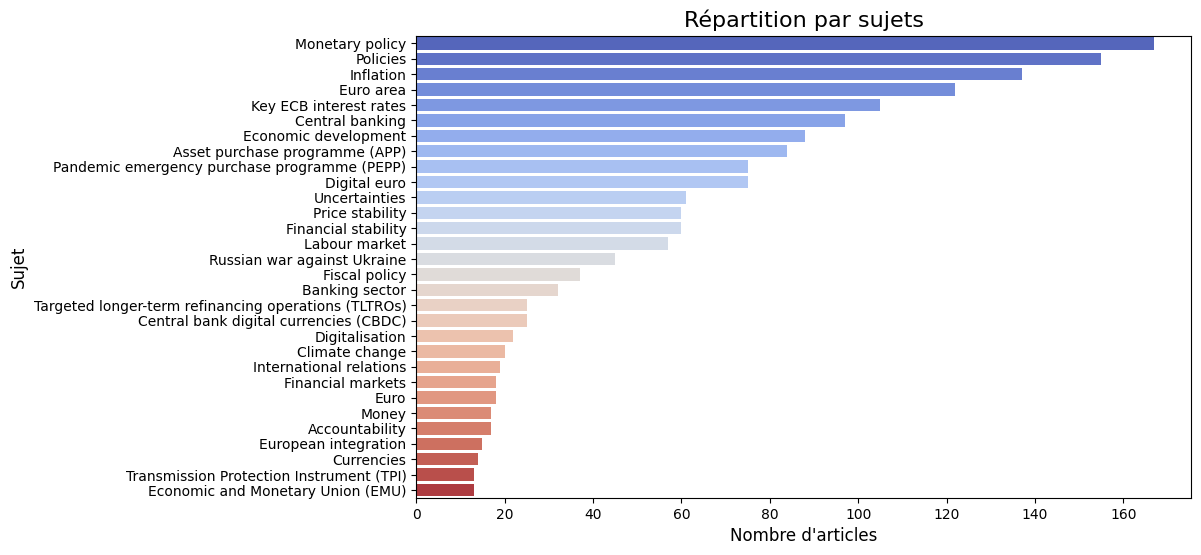

In [ ]:
top_30 = df["topic"].value_counts().head(30).reset_index()
top_30.columns = ["topic", "count"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_30, x="count", y="topic", palette="coolwarm")
plt.title("Répartition par sujets", fontsize=16)
plt.xlabel("Nombre d'articles", fontsize=12)
plt.ylabel("Sujet", fontsize=12)


This bar plot highlights the ECB's focus over time. Core topics like "Monetary Policy" dominate every year, reflecting their importance. Peaks in 2020 and 2022 likely correspond to the COVID-19 pandemic and the energy crisis, with increased mentions of "Asset Purchase Programme (APP)" and "Key ECB Interest Rates." The ECB's priorities clearly adapt to significant economic events.

In [ ]:
df.set_index("date", inplace=True)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


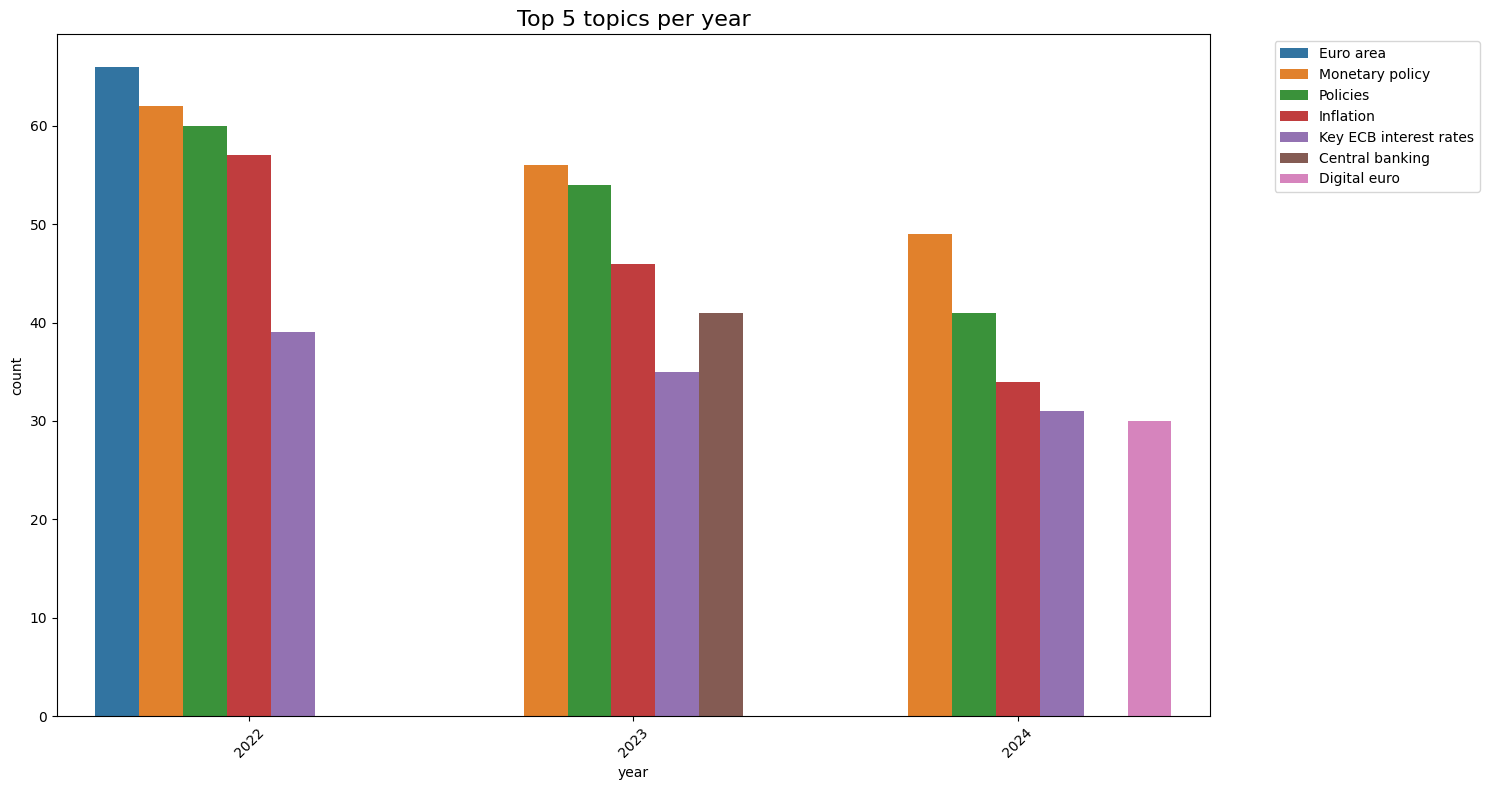

In [ ]:
df['year'] = df.index.year
yearly_top5 = df.groupby(['year', 'topic']).size().reset_index(name='count')
yearly_top5 = yearly_top5.sort_values(['year', 'count'], ascending=[True, False]).groupby('year').head(5)

plt.figure(figsize=(15, 8))
sns.barplot(data=yearly_top5, x='year', y='count', hue='topic', dodge=True, width=0.8)
plt.title('Top 5 topics per year', fontsize=16)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The chart above shows the distribution of topics covered in press articles published by the European Central Bank (ECB). It is evident that most articles focus on monetary policy, general policies, and inflation, reflecting the ECB's core role in macroeconomic regulation.

On the other hand, topics such as financial markets, international relations, and central bank digital currencies (CBDC) are less frequently discussed, despite their strategic importance in the current economic environment.

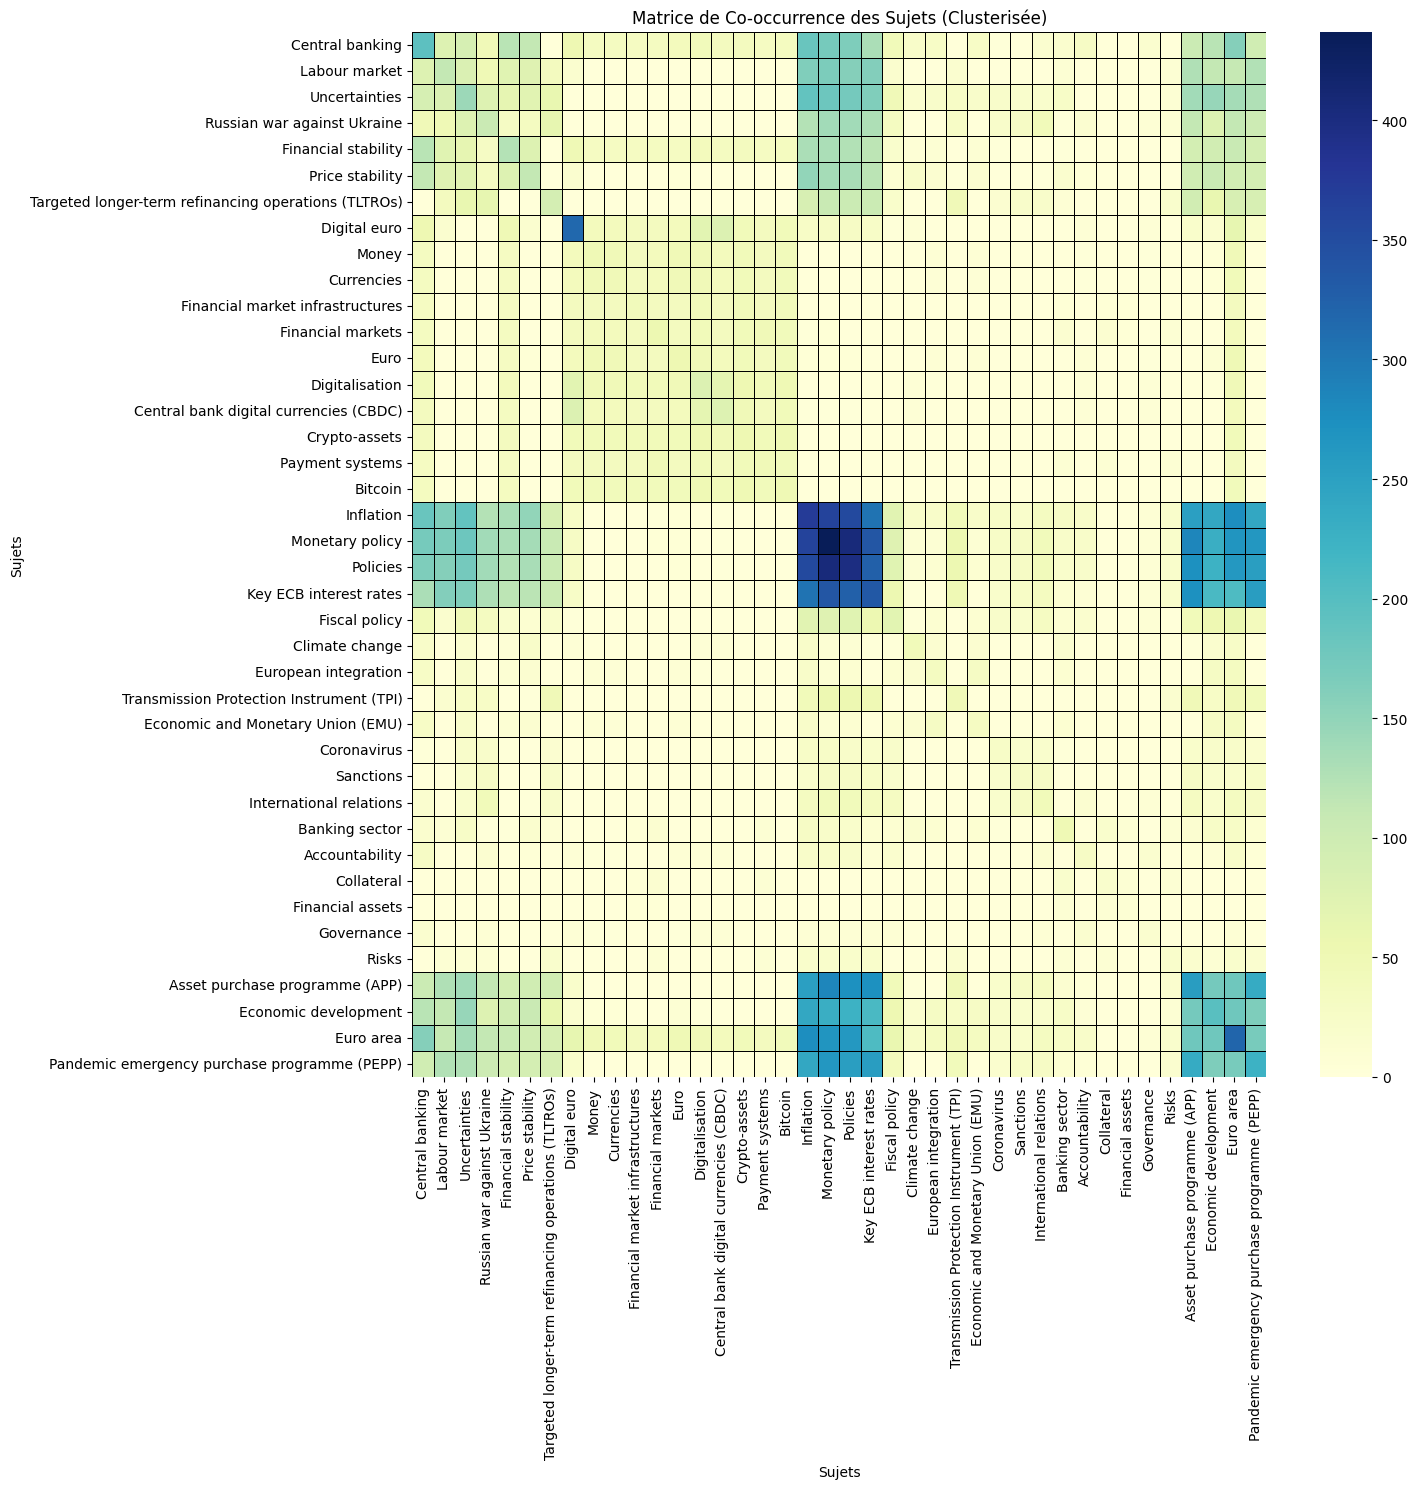

In [ ]:
df = df.explode('topic')
top_topics = df['topic'].value_counts().head(40).index
binary_matrix = pd.crosstab(df.index, df['topic'])[top_topics]
co_occurrence_matrix = binary_matrix.T.dot(binary_matrix)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto').fit(co_occurrence_matrix)
sorted_topics = pd.Series(kmeans.labels_, index=co_occurrence_matrix.columns).sort_values().index
co_occurrence_matrix_sorted = co_occurrence_matrix.loc[sorted_topics, sorted_topics]

plt.figure(figsize=(15, 15))
sns.heatmap(
    co_occurrence_matrix_sorted, cmap='YlGnBu', annot=False, fmt='d', 
    linewidths=0.5, linecolor='black'
)
plt.title("Matrice de Co-occurrence des Sujets (Clusterisée)")
plt.xlabel("Sujets")
plt.ylabel("Sujets")
plt.tight_layout()
plt.show()

## b) The Financial Data We will Consider :

### 1. **Indices**
- **EURO STOXX 50**: Represents the 50 largest stocks in the Eurozone, providing a benchmark for large-cap performance in Europe.

Both indices are combined into a single DataFrame for comparative analysis.

### 2. **European Sector Data**
We analyze sector-specific performance using the STOXX Europe 600 ETFs for the following industries:
- **Banks**: `EXH1.DE` (iShares STOXX Europe 600 Banks)
- **Oil & Gas**: `EXH2.DE` (iShares STOXX Europe 600 Oil & Gas)
- **Technology**: `EXH4.DE` (iShares STOXX Europe 600 Technology)
- **Healthcare**: `EXH3.DE` (iShares STOXX Europe 600 Healthcare)
- **Utilities**: `EXH5.DE` (iShares STOXX Europe 600 Utilities)

### 3. **Data Period and Frequency**
- **Time Period**: 1 year of historical data.
- **Frequency**: Daily closing prices.

[*********************100%***********************]  6 of 6 completed


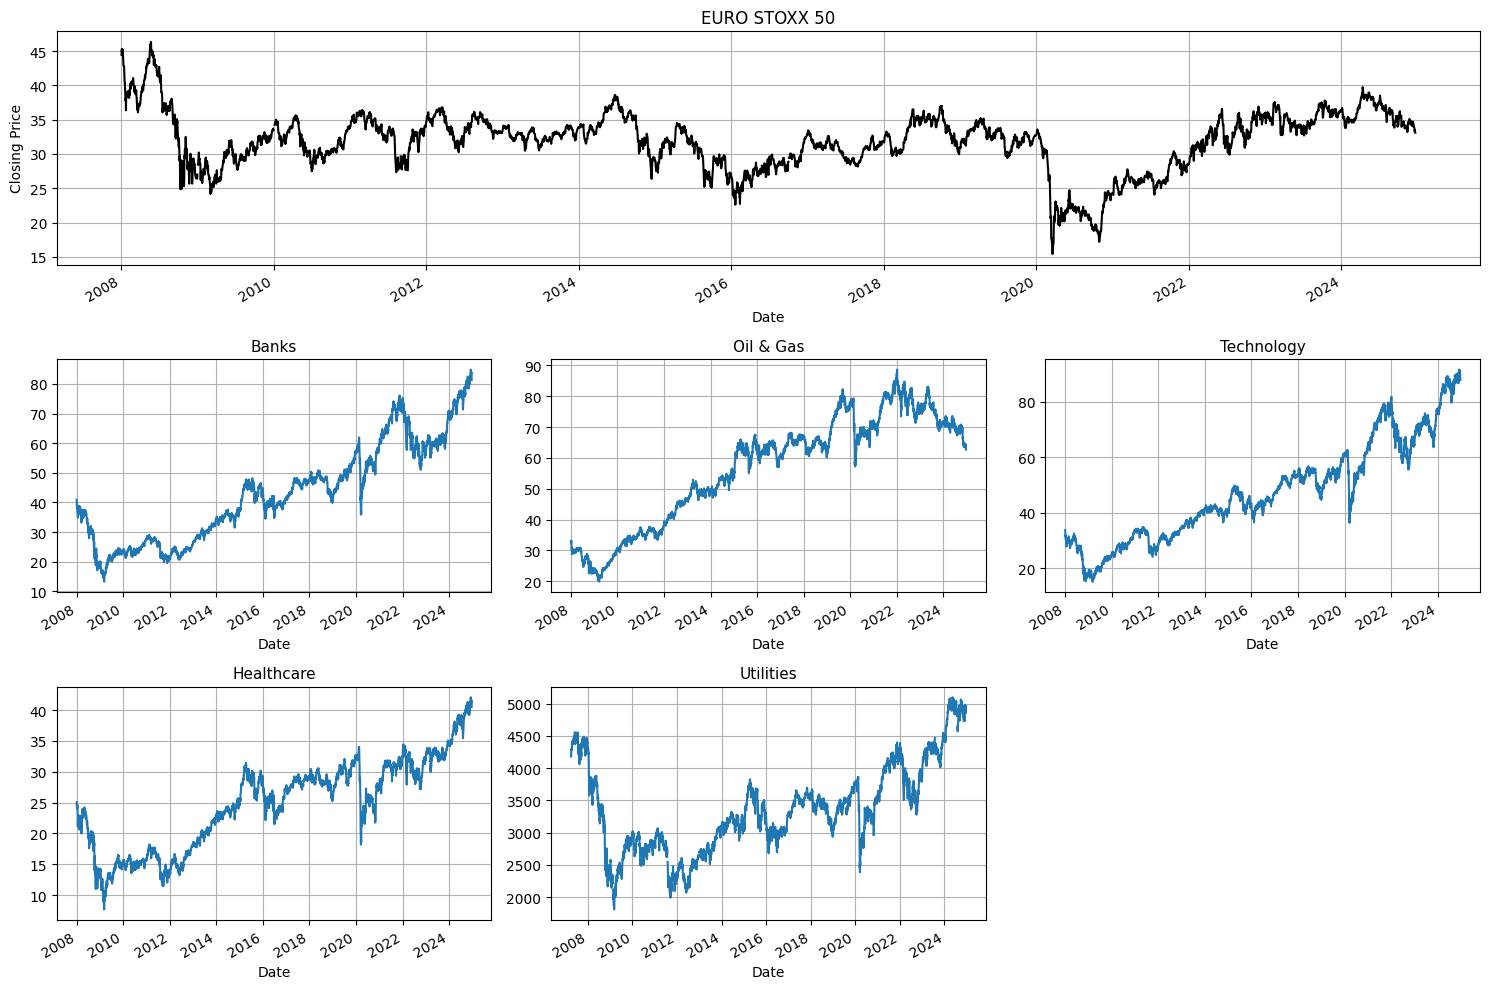

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

tickers = {
    "EURO STOXX 50": "^STOXX50E",
    "Banks": "EXH1.DE",
    "Oil & Gas": "EXH2.DE",
    "Technology": "EXH4.DE",
    "Healthcare": "EXH3.DE",
    "Utilities": "EXH5.DE"
}


data = yf.download(list(tickers.values()), start="2007-01-01")['Close']
data.columns = tickers.keys()

fig = plt.figure(figsize=(15, 10))

ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
data["EURO STOXX 50"].plot(ax=ax0, linewidth=1.5, color='black')
ax0.set_title("EURO STOXX 50", fontsize=12)
ax0.set_xlabel("Date")
ax0.set_ylabel("Closing Price")
ax0.grid()


other_sectors = ["Banks", "Oil & Gas", "Technology", "Healthcare", "Utilities"]

row, col = 1, 0
for sector in other_sectors:
    ax = plt.subplot2grid((3, 3), (row, col))
    data[sector].plot(ax=ax, linewidth=1.5)
    ax.set_title(sector, fontsize=11)
    ax.grid()
    
    col += 1
    if col == 3:
        col = 0
        row += 1

plt.tight_layout()
plt.show()